# Accessing Global Forecast System (GFS) data and simple visualization

### References:
- https://www.nco.ncep.noaa.gov/pmb/products/gfs/#GFS

### Run the following cell to install the dependencies

In [0]:
!python -m pip install --upgrade pip
!pip install xarray[complete]
!pip install eccodes
!pip install ecmwflibs
!pip install cfgrib
!pip install numpy==1.23.0
!pip install alive_progress
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [0]:
# Run this if you are in the databricks environment
dbutils.library.restartPython() 

#### Define a function `file_path()` to fetch the urls in public Azure container

In [0]:
import os

def file_path(cycle_runtime: int, forecast_hour: int, year: int, month: int, day: int, resolution_degree: float) -> str:
    prefix_path = "https://noaagfs.blob.core.windows.net/"
    product_name = "gfs"

    resolution_split = str(resolution_degree).split(".")

    file_path = (
        f"{product_name}/{product_name}.{year}{month:>02}{day:>02}/"
        f"{cycle_runtime:>02}/atmos/{product_name}.t{cycle_runtime:>02}z."
        f"pgrb2.{resolution_split[0]}p{resolution_split[1]:<02}.f{forecast_hour:>03}"
    )

    whole_path = os.path.join(prefix_path, file_path)

    return whole_path


#### Define a function `read_into_xarray_dataset()` to read given url into xarray dataset

References for different keywords:

        filter_by_keys={'typeOfLevel': 'meanSea'}
        filter_by_keys={'typeOfLevel': 'hybrid'}
        filter_by_keys={'typeOfLevel': 'atmosphere', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'atmosphere', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'accum'}
        filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
        filter_by_keys={'typeOfLevel': 'isobaricInPa'}
        filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
        filter_by_keys={'typeOfLevel': 'heightAboveGround'}
        filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
        filter_by_keys={'typeOfLevel': 'heightAboveSea'}
        filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
        filter_by_keys={'typeOfLevel': 'lowCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'lowCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'middleCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'middleCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'highCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'highCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'cloudCeiling'}
        filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
        filter_by_keys={'typeOfLevel': 'tropopause'}
        filter_by_keys={'typeOfLevel': 'maxWind'}
        filter_by_keys={'typeOfLevel': 'isothermZero'}
        filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'}
        filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
        filter_by_keys={'typeOfLevel': 'sigmaLayer'}
        filter_by_keys={'typeOfLevel': 'sigma'}
        filter_by_keys={'typeOfLevel': 'potentialVorticity'}
 

In [0]:
import xarray as xr
import urllib.request
from urllib.error import HTTPError
from typing import Optional

def read_into_xarray_dataset(URL: str, level: str, step: Optional[str] = None):
    try:
        filename, _ = urllib.request.urlretrieve(URL)

        step_key = ["atmosphere", "surface", "lowCloudLayer", "middleCloudLayer", "highCloudLayer"]

        if level in step_key:
            ds = xr.open_dataset(
                filename,
                engine="cfgrib",
                filter_by_keys={"typeOfLevel": level, "stepType": step},
                backend_kwargs={"errors": "ignore"},
            )
        else:
            ds = xr.open_dataset(
                filename, 
                engine="cfgrib", 
                filter_by_keys={"typeOfLevel": level}, 
                backend_kwargs={"errors": "ignore"}
            )

        return ds
    except HTTPError as err:
        if err.code == 404:
            print(f"{URL} does not exist. Please check the parameters again.")

In [0]:
URL = file_path(cycle_runtime=12, forecast_hour=102, year=2024, month=6, day=10, resolution_degree=0.5)
ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

print(URL)
ds

https://noaagfs.blob.core.windows.net/gfs/gfs.20240610/12/atmos/gfs.t12z.pgrb2.0p50.f102


<xarray.Dataset> Size: 5MB
Dimensions:                  (latitude: 361, longitude: 720)
Coordinates:
    time                     datetime64[ns] 8B ...
    step                     timedelta64[ns] 8B ...
    pressureFromGroundLayer  float64 8B ...
  * latitude                 (latitude) float64 3kB 90.0 89.5 ... -89.5 -90.0
  * longitude                (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    valid_time               datetime64[ns] 8B ...
Data variables:
    t                        (latitude, longitude) float32 1MB ...
    r                        (latitude, longitude) float32 1MB ...
    q                        (latitude, longitude) float32 1MB ...
    u                        (latitude, longitude) float32 1MB ...
    v                        (latitude, longitude) float32 1MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-06-14T13:38 GRIB to CDM+CF via cfgrib-0.9.1...

#### filtering the dataset with US boundary, converting it into pandas dataframe and rename and reorder the columns.

In [0]:
df_usa = (ds[['t', 'r', 'q', 'u', 'v']]
          .sel(latitude = slice(50, 24), longitude = slice(235, 293))
          .to_dataframe()
          .sort_values('latitude')
          .reset_index()
          )

df_usa.rename(columns = {'t' : ds['t'].standard_name, 
                         'r' : ds['r'].standard_name, 
                         'q' : ds['q'].standard_name, 
                         'u' : ds['u'].standard_name, 
                         'v' : ds['v'].standard_name}, inplace = True
                         )

df_usa.drop('valid_time', axis = 1, inplace = True)
df_usa = df_usa.iloc[:, [7,8,9,0,1,2,3,4,5,6]]

df_usa.head()

,time,step,pressureFromGroundLayer,latitude,longitude,air_temperature,relative_humidity,specific_humidity,eastward_wind,northward_wind
0,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,293.0,298.419312,78.099998,0.015718,-5.080725,0.213931
1,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,250.0,302.619324,45.700001,0.012068,-2.380725,-1.416069
2,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,250.5,297.619324,79.300003,0.015349,-5.110725,5.593931
3,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,251.0,297.719299,83.099998,0.016165,-2.670725,6.443931
4,2024-06-10 12:00:00,4 days 06:00:00,3000.0,24.0,251.5,298.219299,81.900002,0.016447,-0.340725,5.783931


#### Simple visualization of gfs data

Running |████████████████████| 6/6 [100%] in 9.3s (0.60/s)                      


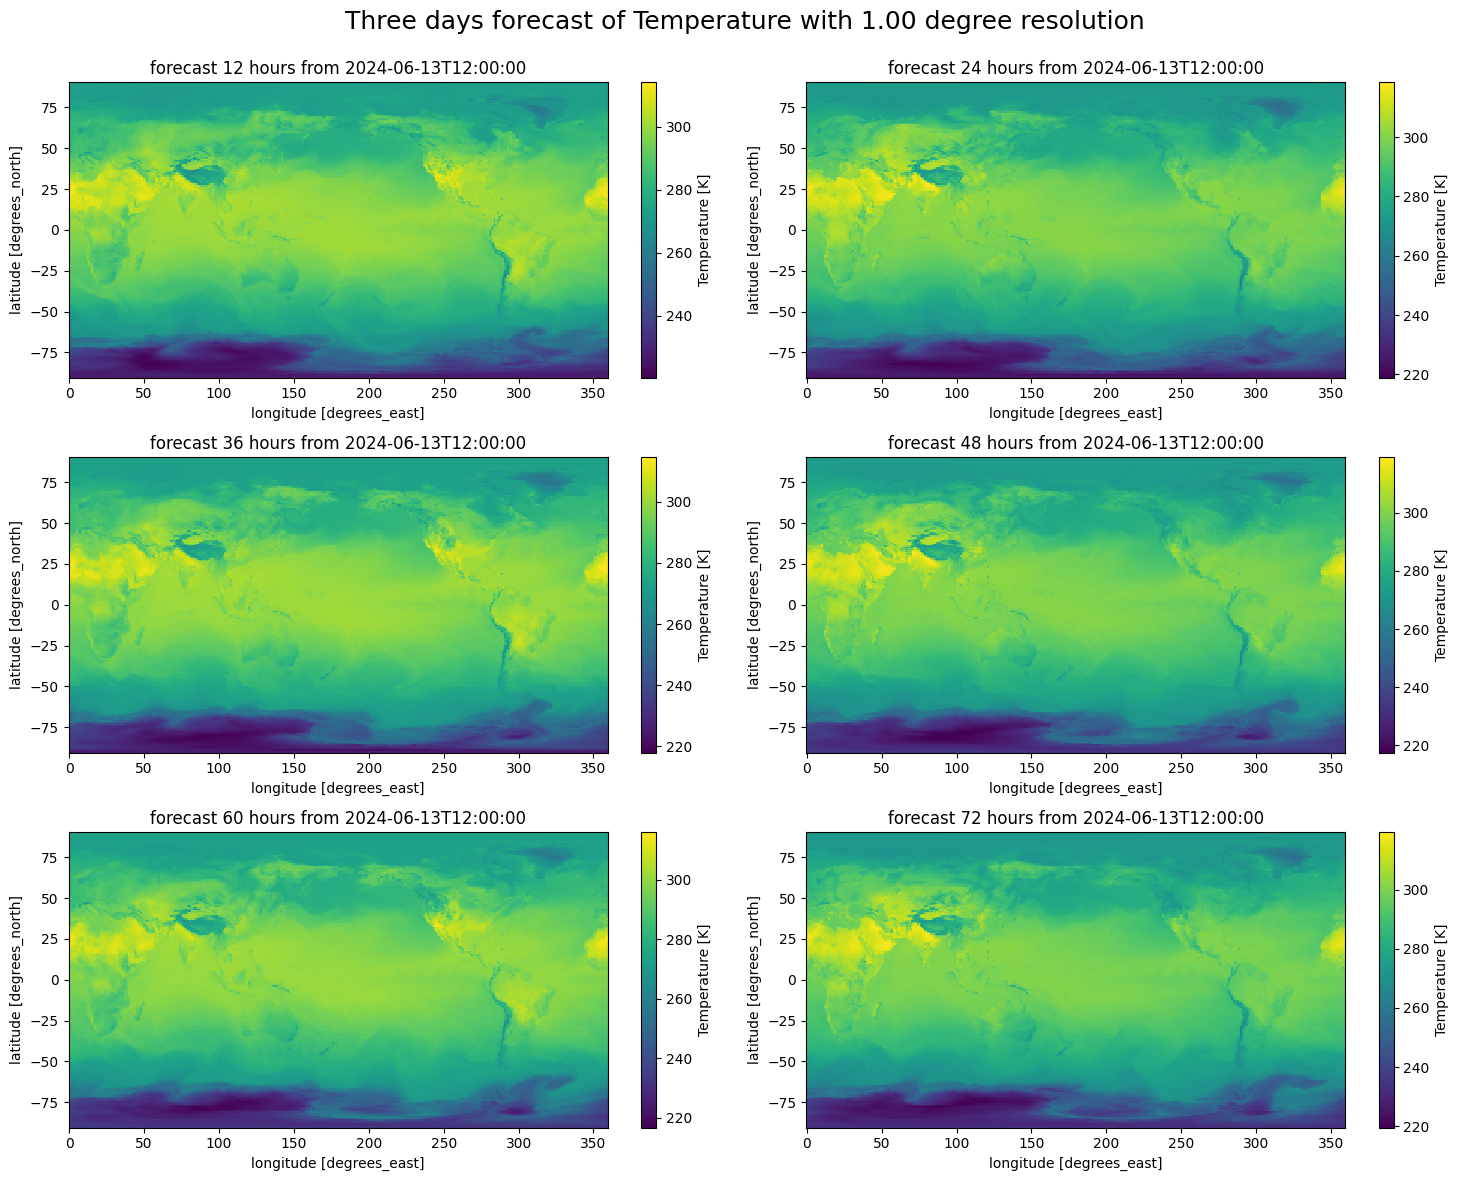

In [0]:
import matplotlib.pyplot as plt
from alive_progress import alive_bar

forecast_hours = [x for x in range(12, 72 + 1, 12)]
fig = plt.subplots(figsize = (15, 12))

rows = len(forecast_hours) // 2 + len(forecast_hours) % 2
cols = 2

with alive_bar(len(forecast_hours), force_tty=True, title='Running', length=20, bar = 'smooth') as bar:
    
    for n, forecast_hour in enumerate(forecast_hours):
        
        URL = file_path(12, forecast_hour, 2024, 6, 13, 1.)

        ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

        ax = plt.subplot(rows, cols, n + 1)
        
        ds['t'].plot(ax = ax)

        plt.title(f"forecast {ds.step.values.astype('timedelta64[h]')} from {ds.time.values.astype('datetime64[s]')}")  

        bar()

plt.suptitle('Three days forecast of Temperature with 1.00 degree resolution', size = 18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()


Running |████████████████████| 3/3 [100%] in 11.7s (0.21/s)                     


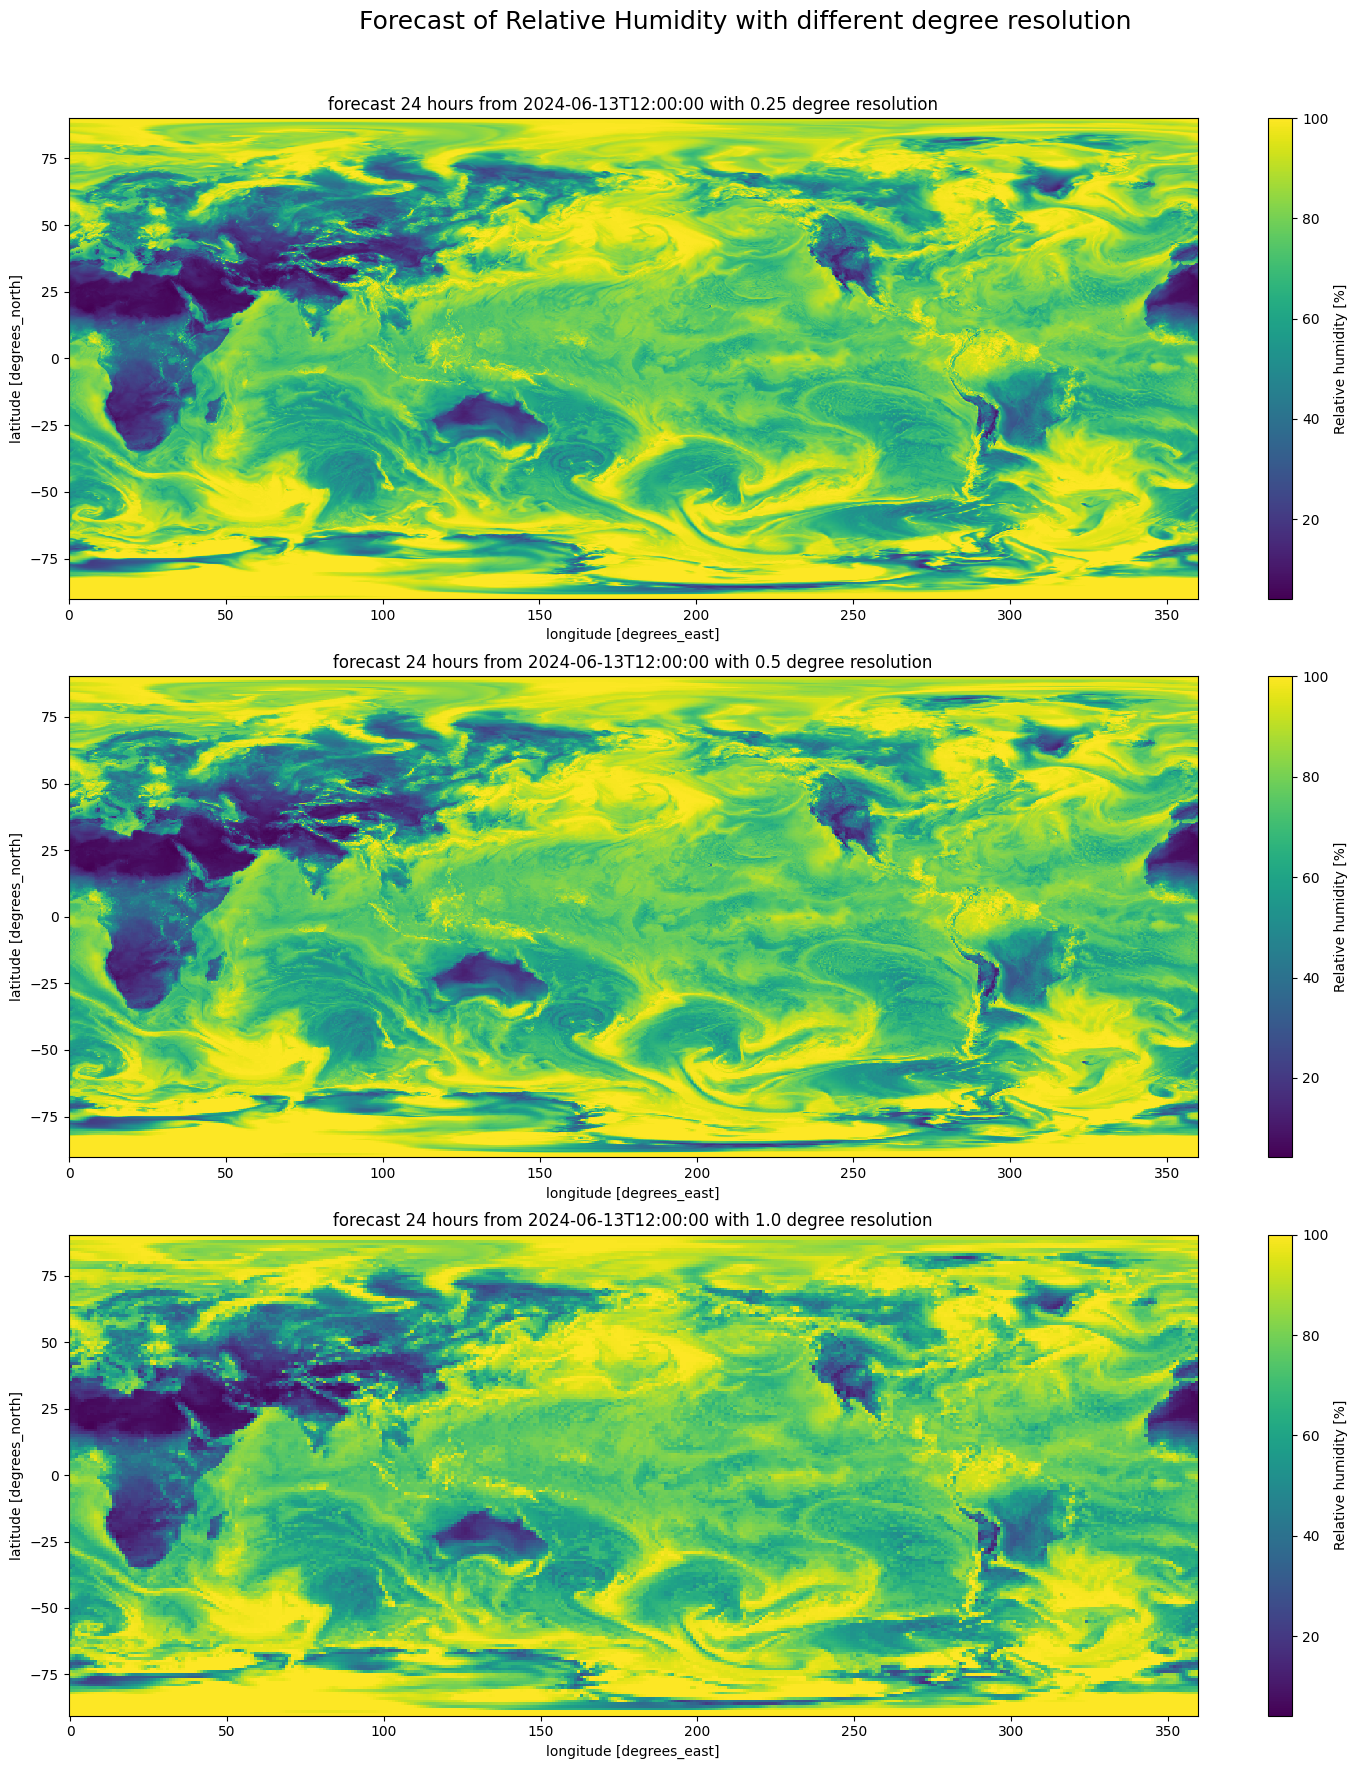

In [0]:
import cartopy.crs as ccrs

fig = plt.subplots(figsize=(15, 18), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

resolution_degrees = [0.25, 0.5, 1.]

with alive_bar(len(resolution_degrees), force_tty=True, title='Running', length=20, bar = 'smooth') as bar:
    
    for n, resolution_degree in enumerate(resolution_degrees):
        
        URL = file_path(12, 24, 2024, 6, 13, resolution_degree)

        ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

        ax = plt.subplot(3, 1, n + 1)
        
        ds['r'].plot(ax = ax)

        plt.title(f"forecast {ds.step.values.astype('timedelta64[h]')} from {ds.time.values.astype('datetime64[s]')} with {resolution_degree} degree resolution")  

        bar()

plt.suptitle('Forecast of Relative Humidity with different degree resolution', size = 18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()